# What's cooking?

A visualization of recipe data from the [Feeding America](https://lib.msu.edu/feedingamericadata) dataset. The visualization below applies to one of the books, feel free to try alternatives. 

**COLAB NOTEBOOK VERSION:** To run this notebook in CoLab, please [click here](https://colab.research.google.com/github/senthilchandrasegaran/words-as-images/blob/main/recipes.ipynb).


In [1]:
## Uncomment the below lines if needed.
# !pip install BeautifulSoup4
# !pip install pandas
# !pip install seaborn
# !pip install scipy
# !pip install numpy

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import numpy as np

In [3]:
with open("data/recipe/cookbook_textencoded/aunt.xml") as fo:
    cookbook_xml = fo.read()

In [4]:
bs_data = BeautifulSoup(cookbook_xml, "xml")
dish_categories = bs_data.find_all('chapter')
data_obj_list = []

for cat in dish_categories:
    heading = cat.find("hd")
    dishes = cat.find_all('purpose')
    for dish in dishes:
        ingredients = dish.parent.find_all('ingredient')
        for ingredient in ingredients :
            data_obj = { "Dish Type" : heading.text.strip('.'),
                         "Dish Name" : dish.text.strip('.'),
                         "Ingredient" : ingredient.text.strip('.,;')}
            data_obj_list.append(data_obj)

df = pd.DataFrame(data_obj_list)
print(len(set(df["Dish Type"].to_list())), "dish categories found.")
print(len(set(df["Dish Name"].to_list())), "dishes found.")
print(len(set(df["Ingredient"].to_list())), "Unique ingredients found.")
df.sample(15)
        

36 dish categories found.
900 dishes found.
1222 Unique ingredients found.


,Dish Type,Dish Name,Ingredient
7338,CONFECTIONERY,NOUGAT,almonds
942,MEATS,WIENER BRATEN,salt
1519,GAME,RAGOUT OF RABBIT,flour
6393,ICING FOR CAKES,BOILED ICING,rosewater
6443,ICING FOR CAKES,UNBOILED ICING,fruit coloring
4291,PUDDINGS,CHILDREN'S FAVORITE DESSERT,lady fingers
3819,PIES,LEMON PIE,lemon juice
1749,ENTREES,GOOSE LIVER WITH MUSHROOM SAUCE,peppers
4565,PUDDING SAUCES,WINE SAUCE,cornstarch
1605,GAME,VENISON AND RABBIT PIE,venison


## Plotting Ingredient vs. Dish co-occurrence
Plotting all dishes vs. all ingredients is unrealistic, so let's choose one category at a time.

In [5]:
soup_df = df[df["Dish Type"] == "SOUPS"]
co_mat = pd.crosstab(soup_df["Dish Name"], soup_df["Ingredient"])

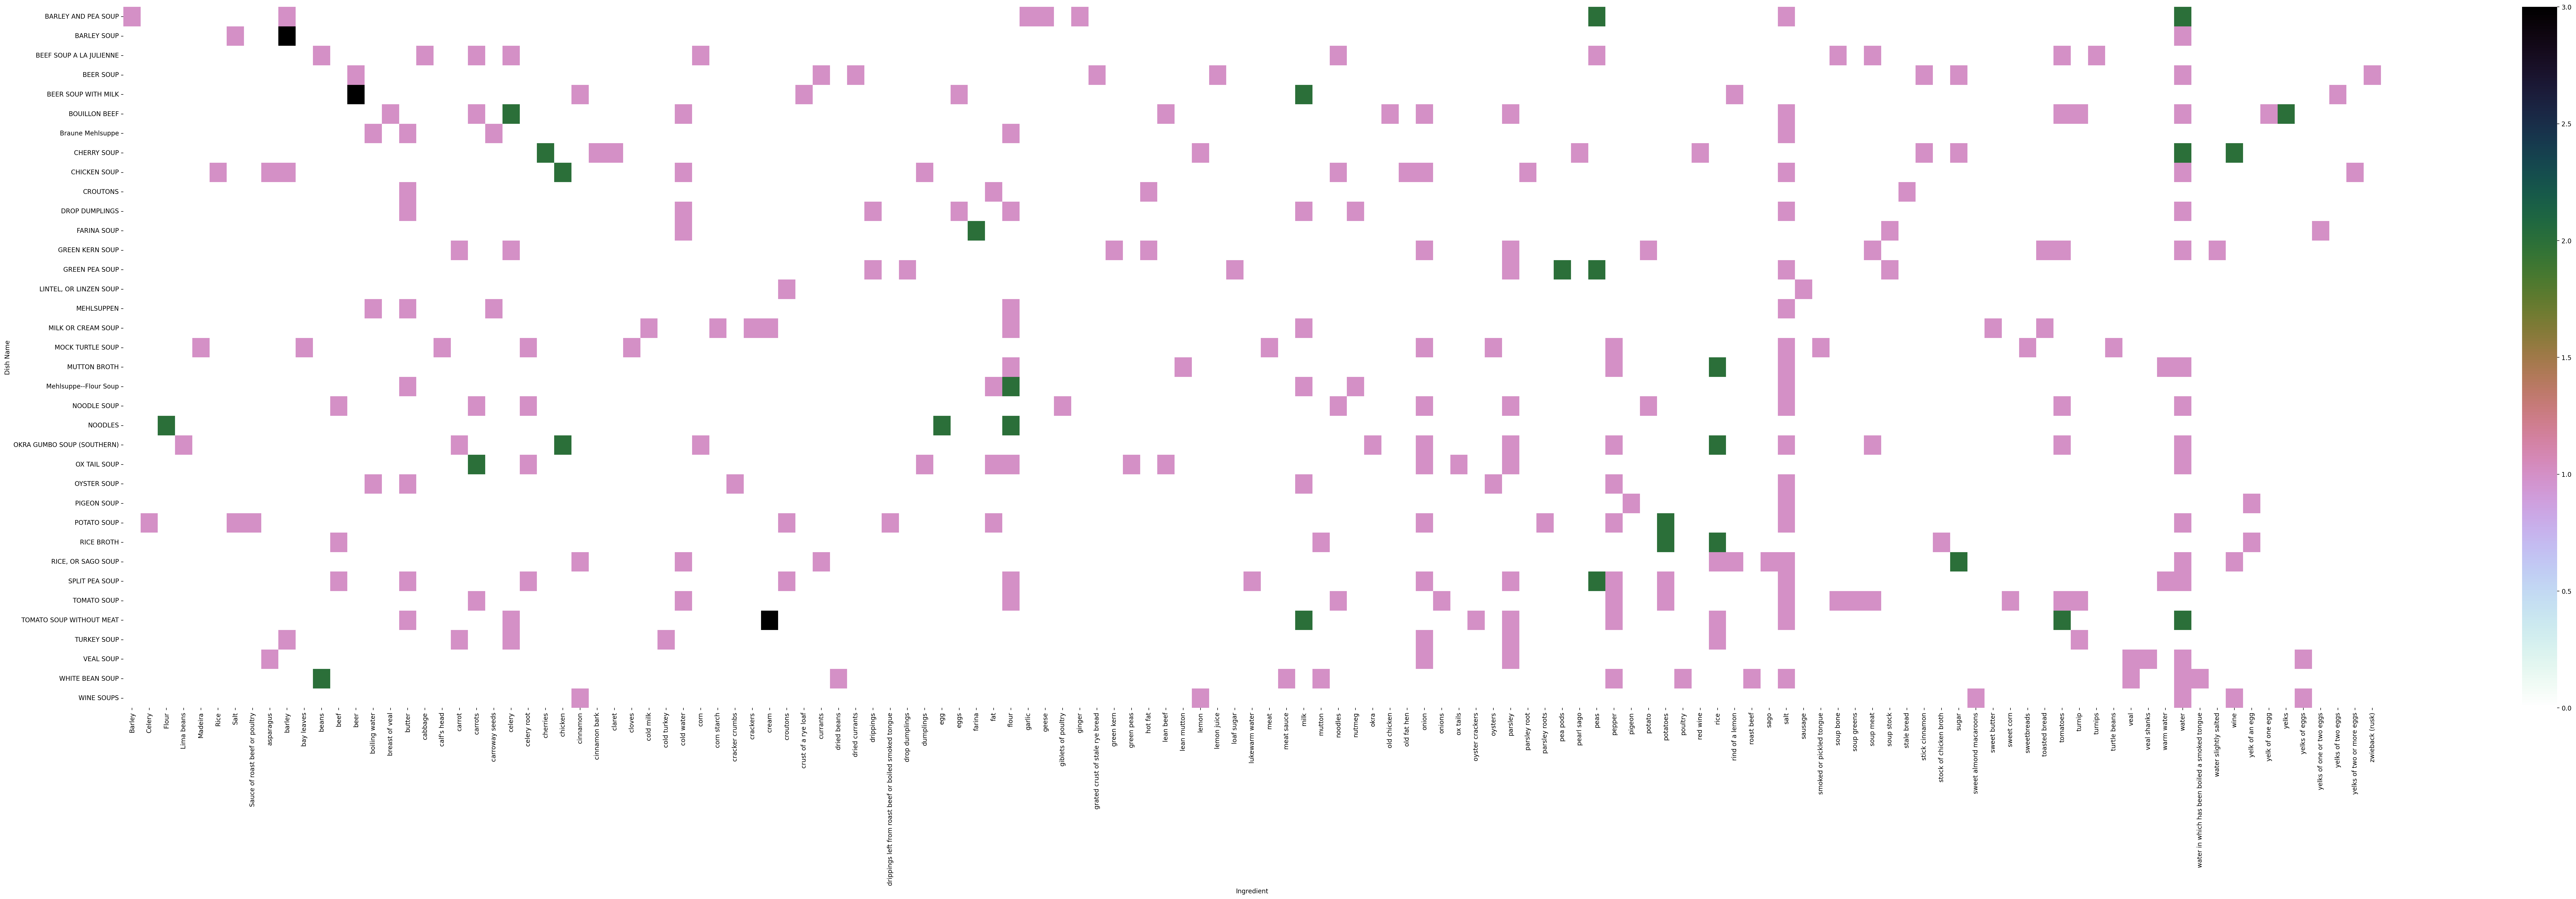

In [6]:
plt.figure(figsize=[80,20], dpi=200)
sns.heatmap(co_mat, cmap='cubehelix_r')
plt.savefig("./plots/soup_ingredient_heatmap.pdf", bbox_inches="tight")

While the above figure shows some patterns (you can immediately see very common ingredients and some very uncommon ones), but we can do better by clustering the dishes based on common ingredients and ingredients based on common dishes.

In [7]:
def plot_similarity_cluster(matrix_df, method='ward', metric='euclidean'):
    ingredients = matrix_df.columns.to_list()
    dishes = matrix_df.index.to_list()
    similarity_matrix = matrix_df[matrix_df.columns[:]].to_numpy()
    colormap = 'cubehelix_r'
    col_min = np.min(similarity_matrix)
    col_max = np.max(similarity_matrix)
    plt.figure(dpi=200)
    cm = sns.clustermap(data=similarity_matrix, vmin=col_min, vmax=col_max,
                        figsize=[len(ingredients)/5,len(dishes)/3], 
                        method=method, metric=metric,
                        cbar_kws=None, row_cluster=True, col_cluster=True,
                        #metric="correlation", method="single", 
                        cmap=colormap, 
                        yticklabels=dishes, 
                        xticklabels=ingredients,
                        # cbar=False, 
                        standard_scale=None)
    cm.ax_row_dendrogram.set_visible(True)
    cm.ax_col_dendrogram.set_visible(True)
    cm.cax.set_visible(False)
    plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, 
             rotation_mode="anchor", ha='left')
    plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45,
             rotation_mode='anchor', ha='right')
    plt.savefig('plots/dish_ingredient_clusters_threshold'+metric+'.pdf', dpi=300, bbox_inches='tight')
    return df, cm

<Figure size 1280x960 with 0 Axes>

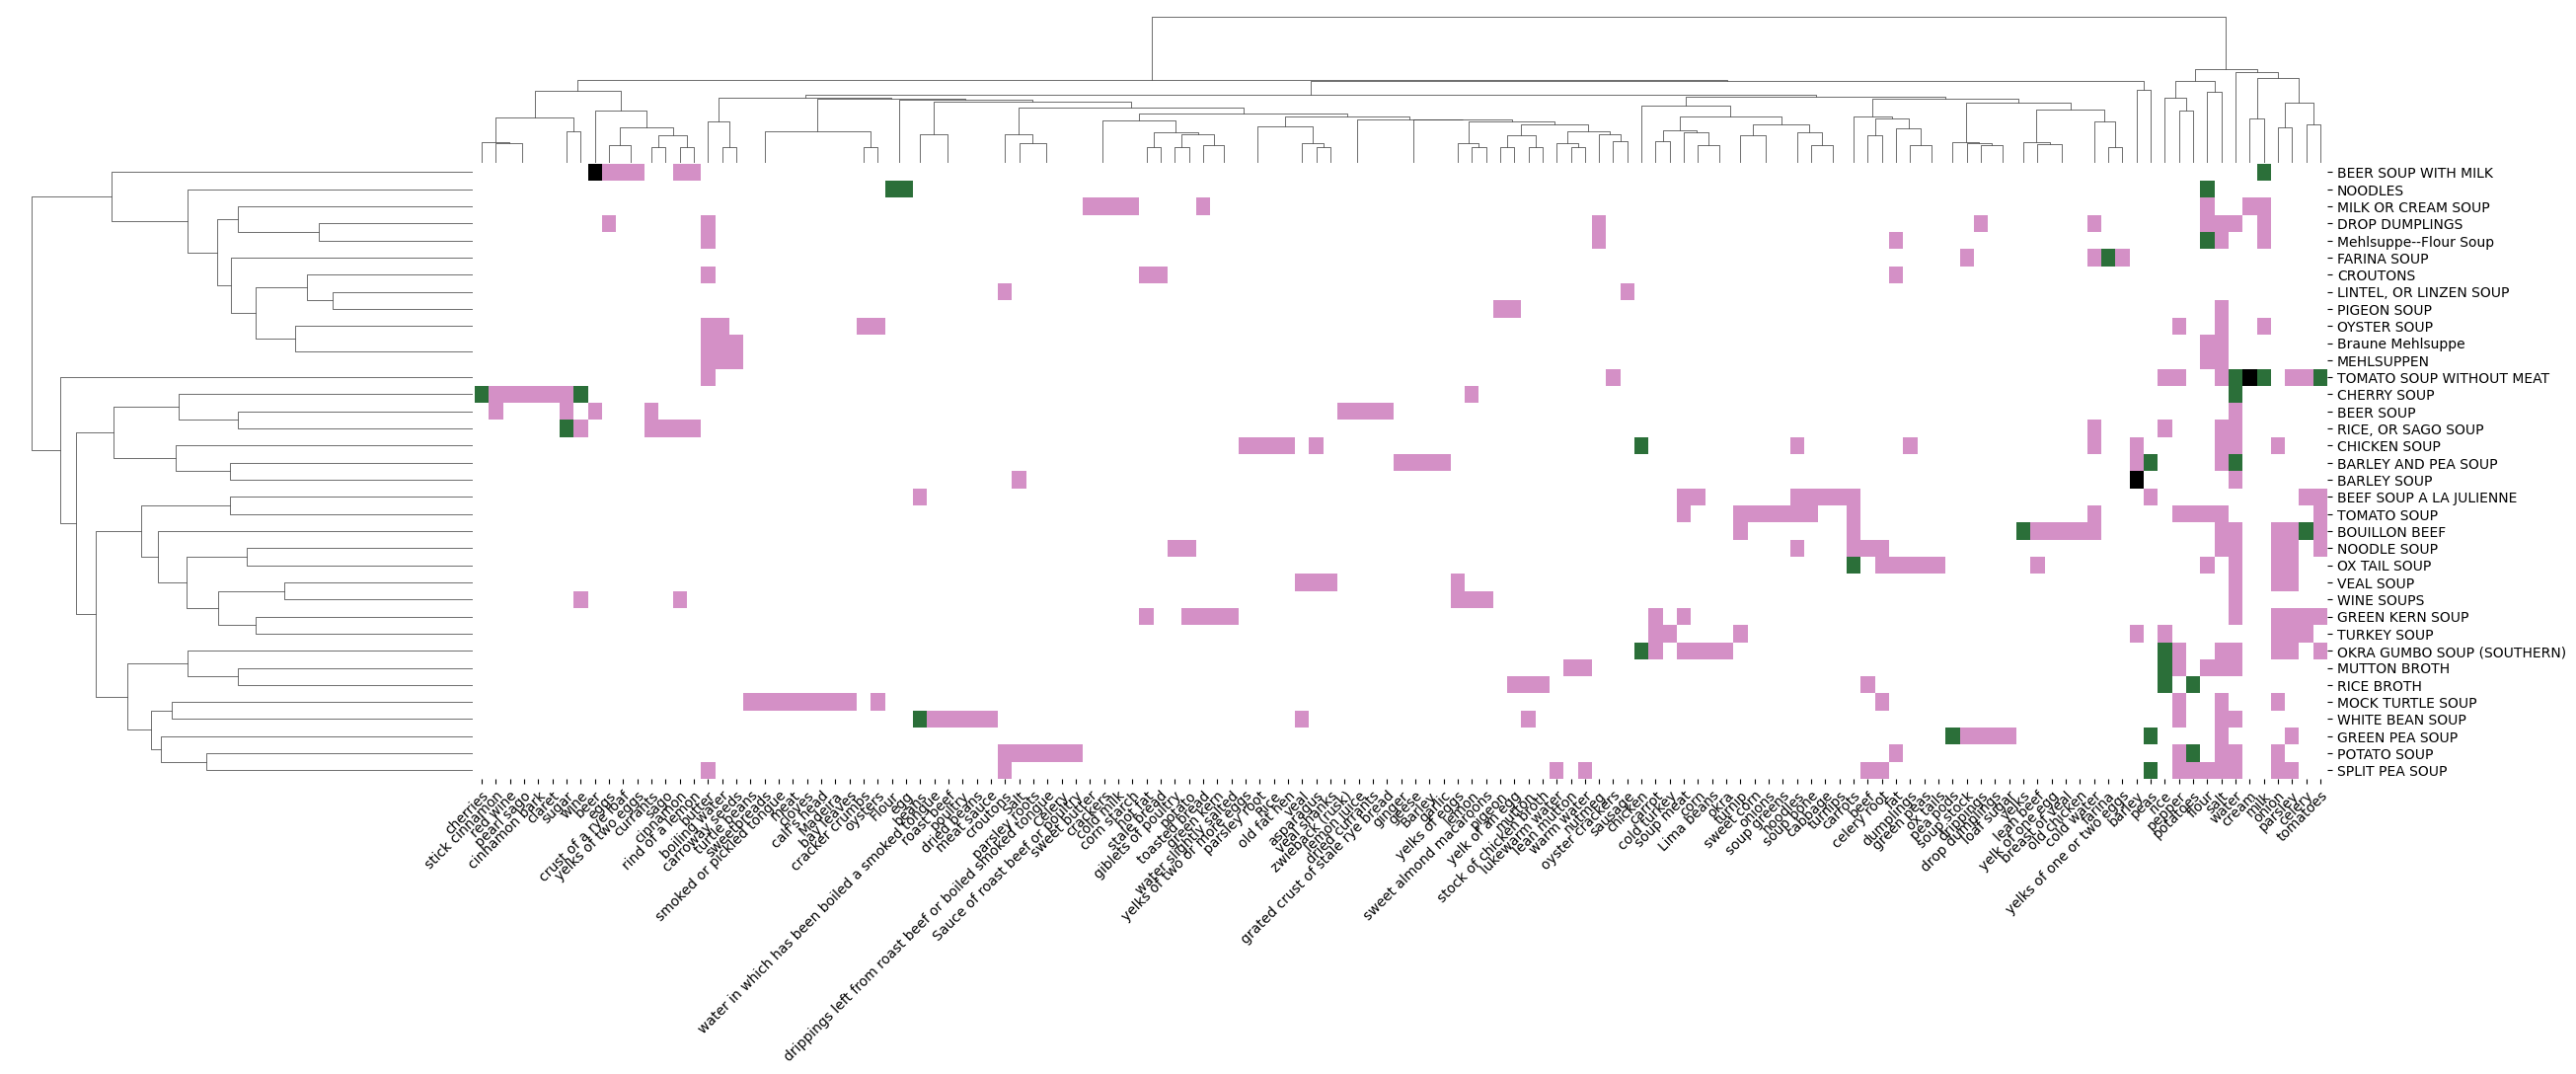

In [8]:
cluster_df,clustermap = plot_similarity_cluster(co_mat)

## Exercise
  * Try alternative clustering [methods (click to see details)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) and [metrics (click to see details)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) to see what works best for you.
  * Try difference recipe categories.
  * Look at the raw dataset. Are there other aspects of cooking you would like visualized?